# Personality prediction

## Import the data and the libraries

In [1]:
!pip install scikit-learn==0.23.2

In [2]:
! pip install -U nltk

Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.5)


In [3]:
!pip install pyspellchecker 

In [4]:
!pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)


In [22]:
#Upload the important libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer ,CountVectorizer
from sklearn.metrics import matthews_corrcoef
import tensorflow as tf
from sklearn.model_selection import GridSearchCV 
import sklearn
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from gensim import utils
import gensim.parsing.preprocessing as gsp
from spellchecker import SpellChecker
from tqdm import tqdm
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.preprocessing import MultiLabelBinarizer
import nltk
nltk.download('wordnet')
import nltk
nltk.download('punkt')
from sklearn.preprocessing import LabelEncoder
import torch
import io
import re

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
# This cell for GPU work

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [10]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [11]:
from google.colab import files
uploaded= files.upload()

Saving mbti_1.csv to mbti_1 (1).csv


In [14]:
#data= pd.read_csv('mbti_1.csv', header=0)
#Reading the data
data= pd.read_csv(io.StringIO(uploaded['mbti_1.csv'].decode('utf-8')))

## Exploaratry data analysis 

In [15]:
print(data.head())
print('The columns are:',data.columns)
print('The Classes of  Types column are :', len(data['type'].value_counts()))
data['type']= data['type'].astype('category')

   type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...
The columns are: Index(['type', 'posts'], dtype='object')
The Classes of  Types column are : 16


In [16]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   type    8675 non-null   category
 1   posts   8675 non-null   object  
dtypes: category(1), object(1)
memory usage: 77.1+ KB
None


In [17]:
print(data['type'].value_counts())
print(data['type'].value_counts().sum())
print(len(data['type'].value_counts()))

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64
8675
16


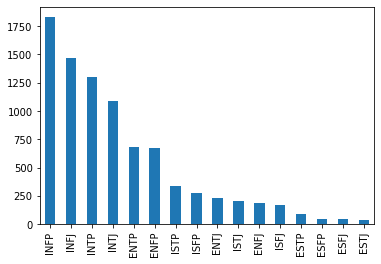

In [18]:
data['type'].value_counts().sort_values(ascending=False).plot(kind='bar')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

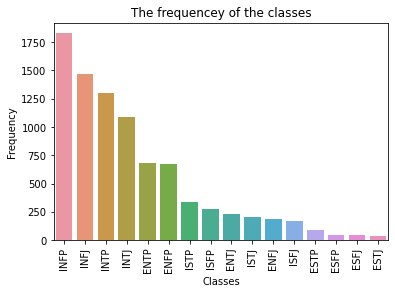

In [19]:
g=sns.countplot(data=data,
         x='type', order=data['type'].value_counts().index)

g.set_title("The frequencey of the classes") 

g.set(xlabel="Classes", ylabel="Frequency") 
# Rotate x-tick labels
plt.xticks(rotation=90)

## Data Cleaning

In [20]:
y= data['type']
X= data['posts']

In [26]:
print('The Real Type of the observation are :' ,type(X))
X=pd.DataFrame(X)
print('The New Type of the observation are :', type(X))
print('The Features are:',X.columns)

#1 Replace all non letter characters with a whitespace
X['text_clean'] = X['posts'].str.replace('[^a-zA-Z]', ' ')
# 2 Change to lower case
X['text_clean'] = X['text_clean'].str.lower()

print(X.info())

The Real Type of the observation are : <class 'pandas.core.frame.DataFrame'>
The New Type of the observation are : <class 'pandas.core.frame.DataFrame'>
The Features are: Index(['posts'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   posts       8675 non-null   object
 1   text_clean  8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB
None


In [27]:
#drop the messy column
X= X.drop(['posts'], axis=1)

In [28]:
#See the data after Cleaning it and dropping the messy column

print(X.head())
print('The number of Null observation are:' ,X.isnull().sum())
print('The columns are:',X.columns)
print('The type of the column is:',X.dtypes)
X['text_clean']=X['text_clean'].astype(str) 
#X['New_Lables']= X['New_Lables'].astype('str')

                                          text_clean
0   http   www youtube com watch v qsxhcwe krw   ...
1   i m finding the lack of me in these posts ver...
2   good one          https   www youtube com wat...
3   dear intp    i enjoyed our conversation the o...
4   you re fired    that s another silly misconce...
The number of Null observation are: text_clean    0
dtype: int64
The columns are: Index(['text_clean'], dtype='object')
The type of the column is: text_clean    object
dtype: object


In [29]:
# Clean everything 

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords,
           gsp.strip_short
          ]


def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s


X['text_clean'] = X['text_clean'].apply(lambda x : clean_text(x))

In [30]:
print(X['text_clean'].head(5))

0    http www youtube com watch qsxhcwe krw http me...
1    finding lack posts alarming sex boring positio...
2    good https www youtube com watch fhigbolffgw c...
3    dear intp enjoyed conversation day esoteric ga...
4    fired silly misconception approaching logicall...
Name: text_clean, dtype: object


## Feature Enignnering

In [31]:
# We applied CountVectorizer because we want to take care on n-grams, abd Bag of Words MINOCCc=0.05 and MAXOCCd=0.5
# Instantiate CountVectorizer
cv = CountVectorizer(analyzer="word", 
                             max_features=1500, 
                             tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,  
#                             ngram_range=(1,1),
                             max_df=0.5,
                             min_df=0.1) # we can manuplite min_df
# Fit the vectorizer
cv_transformed= cv.fit_transform(X['text_clean'])
# Create a DataFrame with these features
cv_df = pd.DataFrame(cv_transformed.toarray(), 
                     columns=cv.get_feature_names()).add_prefix('Counts_')
#Isolate the row to be examined
sample_row_cv = cv_df.iloc[0]

#Print the top 5 words of the sorted output
print(sample_row_cv.sort_values(ascending=False).head())

print('The Shape of the data After the CountVectorizer is:',cv_df)
print('The New Features after BOW and N-Grams are:',cv_df.columns)

Counts_http       21
Counts_youtube    16
Counts_jpg         6
Counts_https       3
Counts_video       3
Name: 0, dtype: int64
The Shape of the data After the CountVectorizer is:       Counts_ability  Counts_able  ...  Counts_younger  Counts_youtube
0                  0            0  ...               0              16
1                  0            1  ...               0               1
2                  2            1  ...               0               3
3                  0            2  ...               0               2
4                  0            0  ...               0               1
...              ...          ...  ...             ...             ...
8670               0            0  ...               1               5
8671               0            0  ...               0               0
8672               0            0  ...               0               2
8673               0            2  ...               0               0
8674               0            1  ...  

In [32]:
# One Hot Encode the Predicted Values
pred=pd.get_dummies(y)
print('The Shape of the Data Frame after one hot encoding is:',pred.shape)
print(pred.tail())

The Shape of the Data Frame after one hot encoding is: (8675, 16)
      ENFJ  ENFP  ENTJ  ENTP  ESFJ  ESFP  ...  INTJ  INTP  ISFJ  ISFP  ISTJ  ISTP
8670     0     0     0     0     0     0  ...     0     0     0     1     0     0
8671     0     1     0     0     0     0  ...     0     0     0     0     0     0
8672     0     0     0     0     0     0  ...     0     1     0     0     0     0
8673     0     0     0     0     0     0  ...     0     0     0     0     0     0
8674     0     0     0     0     0     0  ...     0     0     0     0     0     0

[5 rows x 16 columns]


In [36]:
#Split the data into train and test with 25 percent of testing data 

x_train, x_test, y_train, y_test = train_test_split(cv_df,y,test_size=0.25, random_state=42, shuffle = True 
                                                    ,stratify=y)

print('The Shape of the Training observations are:',x_train.shape)
print('The Shape of the Training Labels are:',y_train.shape)
print('The Shape of the Testing observations are:',x_test.shape)
print('The Shape of the Testing Labels are:',y_test.shape)

The Shape of the Training observations are: (6506, 696)
The Shape of the Training Labels are: (6506,)
The Shape of the Testing observations are: (2169, 696)
The Shape of the Testing Labels are: (2169,)


## Run ML algorithms




In [37]:
# Applying Random Forest Classifier

# Create a based model
rf = RandomForestClassifier()


# Creating Parameter Space
param_grid = {
    'bootstrap': [True],
    'max_depth': [20,40],
    'min_samples_leaf': [2, 4],
    'min_samples_split': [2,4],
    'n_estimators': [100, 200]
}

# Instantiate the grid search model
rf_cv = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
rf_cv.fit(x_train, y_train)
print('The best estimator hyperparameters are: ',rf_cv.best_params_)

best_rf_cv = rf_cv.best_estimator_

#Predict the y test with the best parameters

pred_RF_cv= best_rf_cv.predict(x_test)

# Use accuracy_score function to get the accuracy
print("The Accuracy of Random Forest is ",accuracy_score(y_test,pred_RF_cv))
print("The Matthew Correlation Coffecients of  Random Forest is ",matthews_corrcoef(y_test,pred_RF_cv))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.2min finished


The best estimator hyperparameters are:  {'bootstrap': True, 'max_depth': 40, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 200}
The Accuracy of Random Forest is  0.611802674043338
The Matthew Correlation Coffecients of  Random Forest is  0.5464328964340988


In [43]:
#Extreme Gradient Boosting 

#DM_train = xgb.DMatrix(data= x_train, label= y_train)
#DM_test =  xgb.DMatrix(data= x_test, label= y_test)

# Instantiate the regressor: gbm
gbm = xgb.XGBClassifier(objective='multi:softmax')


#Grid Search cv for XG boost
gbm_param_grid =  {
    'n_estimators': [50],
    'reg_alpha': [1.1],
    'reg_lambda': [1.1]
}


# Perform grid search: grid_mse
gbm_cv = GridSearchCV(estimator= gbm, param_grid=gbm_param_grid,scoring="accuracy",cv=5,verbose=1,n_jobs = -1)
gbm_cv.fit(x_train,y_train)
print('The best estimator hyperparameters are: ',gbm_cv.best_params_)
best_gbm_cv=gbm_cv.best_estimator_

#Predict the y test with the best parameters
pred_gbm_cv= best_gbm_cv.predict(x_test)

# Use accuracy_score function to get the accuracy
print("The Accuracy of Extreme Gradient Boosting is ",accuracy_score(y_test,pred_gbm_cv))
print("The Matthew Correlation Coffecients of Extreme Gradient Boosting is ",matthews_corrcoef(y_test,pred_gbm_cv))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished


The best estimator hyperparameters are:  {'n_estimators': 50, 'reg_alpha': 1.1, 'reg_lambda': 1.1}
The Accuracy of Extreme Gradient Boosting is  0.6740433379437529
The Matthew Correlation Coffecients of Extreme Gradient Boosting is  0.6220220925090135


In [40]:
# Applying Multinomial Naive bayes

#x_train= x_train.drop(subset=['affin_sentiment_score'])
#x_test= x_test.drop(subset=['affin_sentiment_score'])


mnb = MultinomialNB()

# Creating Parameter Space
parameters ={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}  

#'pca_n_components': list(range(1,x_train.shape[1]+1,1))
# Perform grid search: grid_mse
mnb_cv = GridSearchCV(estimator= mnb, param_grid= parameters, verbose=1)
mnb_cv.fit(x_train, y_train)
print('The best estimator hyperparameters are: ',mnb_cv.best_params_)
best_mnb_cv=mnb_cv.best_estimator_


#Predict the y test with the best parameters
pred_mnb_cv= best_mnb_cv.predict(x_test)

# Use accuracy_score function to get the accuracy

print("The Accuracy of Multinomial Naive Bayes is: ", accuracy_score(y_test,pred_mnb_cv))
print("The Matthew Correlation Coffecients of Multinomial Navie Bayes is: ",matthews_corrcoef(y_test,pred_mnb_cv))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The best estimator hyperparameters are:  {'alpha': 0.1}
The Accuracy of Multinomial Naive Bayes is:  0.5928999538958045
The Matthew Correlation Coffecients of Multinomial Navie Bayes is:  0.5384094940017031


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    4.5s finished


In [41]:
# Instate the SVM
SVM = SVC()


# Creating Parameter Space
params= {'C':[0.1,0.5, 1],}


# Instantiate the GridSearchCV object and run the search
SVM_cv= GridSearchCV(SVM, param_grid= params)
                               
SVM_cv.fit(x_train, y_train)

# Report the best parameters
print("Best CV params", SVM_cv.best_params_) 
best_SVM_cv = SVM_cv.best_estimator_

#Predict the y test with the best parameters

pred_SVM_cv= best_SVM_cv.predict(x_test)

# Use accuracy_score function to get the accuracy
print("The Accuracy of SVM is ",accuracy_score(y_test,pred_SVM_cv))
print("The Matthew Correlation Coffecients of SVM is ",matthews_corrcoef(y_test,pred_SVM_cv))

Best CV params {'C': 1}
The Accuracy of SVM is  0.6597510373443983
The Matthew Correlation Coffecients of SVM is  0.6047061324669712
